## Import Data

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

        

In [21]:
INPUT_FOLDER = "preproc"
OUTPUT_FOLDER = "enrich"

In [22]:
key = "us_companies"
df_us_companies = pd.read_csv(f"data/{INPUT_FOLDER}/{key}.csv")
df_us_companies.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SimFinId                       5020 non-null   int64  
 1   Company Name                   5020 non-null   object 
 2   IndustryId                     5020 non-null   float64
 3   ISIN                           5020 non-null   object 
 4   End of financial year (month)  5020 non-null   float64
 5   Number Employees               5020 non-null   float64
 6   Business Summary               5020 non-null   object 
 7   Market                         5020 non-null   object 
 8   CIK                            5020 non-null   float64
 9   Main Currency                  5020 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 392.3+ KB


In [23]:
key = "us-shareprices-daily"
df_us_share_price = pd.read_csv(f"data/{INPUT_FOLDER}/{key}.csv", parse_dates=["Date"])
df_us_share_price.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5815913 entries, 0 to 5815912
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Ticker              5815913 non-null  object        
 1   SimFinId            5815913 non-null  int64         
 2   Date                5815913 non-null  datetime64[ns]
 3   Open                5815913 non-null  float64       
 4   High                5815913 non-null  float64       
 5   Low                 5815913 non-null  float64       
 6   Close               5815913 non-null  float64       
 7   Adj. Close          5815913 non-null  float64       
 8   Volume              5815913 non-null  int64         
 9   Dividend            5815913 non-null  float64       
 10  Shares Outstanding  5815913 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 488.1+ MB


In [24]:
#join df_us_share_price with df_us_companies on SimFinId
df = pd.merge(df_us_share_price, df_us_companies, on="SimFinId", how="left")

df.head()

,Ticker,SimFinId,Date,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding,Company Name,IndustryId,ISIN,End of financial year (month),Number Employees,Business Summary,Market,CIK,Main Currency
0,A,45846,2019-04-12,81.43,82.06,80.90,80.98,77.77,1249295,0.0,317515869.0,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD
1,A,45846,2019-04-15,81.00,81.13,79.91,80.40,77.22,1627268,0.0,317515869.0,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD
2,A,45846,2019-04-16,80.82,80.96,77.19,77.55,74.48,3441597,0.0,317515869.0,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD
3,A,45846,2019-04-17,78.15,78.32,74.46,75.43,72.44,4471971,0.0,317515869.0,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD
4,A,45846,2019-04-18,75.73,76.54,75.31,76.17,73.16,2874195,0.0,317515869.0,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD


## Import Function

In [ ]:
#function
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def train_xgboost_model(data, simfin_id, last_date):
    # Filter the DataFrame to get the last 60 days of data
    data = data[['SimFinId', 'Date', 'Close']]
    data = data.set_index(['SimFinId', 'Date'])
    last_date = pd.to_datetime(last_date)
    sixty_days_prior = last_date - pd.DateOffset(days=60)
    data = data[(data.index.get_level_values('Date') > sixty_days_prior) & (data.index.get_level_values('Date') <= last_date)]

    # Rename close to target
    data = data.rename(columns={'Close': 'target'})
    # Filter the DataFrame based on the provided SimFinId
    data_filtered = data[data.index.get_level_values('SimFinId') == simfin_id]
    
    # Extract useful features from the Date column
    data_filtered['year'] = data_filtered.index.get_level_values('Date').year
    data_filtered['month'] = data_filtered.index.get_level_values('Date').month
    data_filtered['day'] = data_filtered.index.get_level_values('Date').day
    data_filtered['dayofweek'] = data_filtered.index.get_level_values('Date').dayofweek
    data_filtered['lag1'] = data_filtered['target'].shift(1)
    

    # Prepare the data
    X = data_filtered.drop(columns=['target'])
    y = data_filtered['target']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train an XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Predict the next 15 days
    future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=1, freq='B')  # Business days
    future_data = pd.DataFrame(index=pd.MultiIndex.from_product([[simfin_id], future_dates], names=['SimFinId', 'Date']))
    future_data['year'] = future_data.index.get_level_values('Date').year
    future_data['month'] = future_data.index.get_level_values('Date').month
    future_data['day'] = future_data.index.get_level_values('Date').day
    future_data['dayofweek'] = future_data.index.get_level_values('Date').dayofweek
    future_data['lag1'] = data_filtered['target'].iloc[-1]
    
    future_predictions = model.predict(future_data)
    future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions})
    
    return future_predictions_df

# Example usage
# Assuming 'data' is your DataFrame and 'SimFinId' is part of the index
# simfin_id = 59265
# date_for_model = pd.to_datetime('2024-03-04')  # Convert string to datetime
# model, train_mse, test_mse, future_predictions = train_xgboost_model(data, simfin_id, date_for_model)
# print(f"Train Mean Squared Error: {train_mse}")
# print(f"Test Mean Squared Error: {test_mse}")
# print(f"Future Predictions: {future_predictions}")

In [26]:
"""# Function trading strategy
def trading_strategy (future_predictions_df):
    low = prediction_df['Predicted_Close'].min()
    date_low = prediction_df['Date'][prediction_df['Predicted_Close'].idxmin()].strftime('%Y-%m-%d')
    high_after_date_low = prediction_df[prediction_df['Date'] > date_low]['Predicted_Close'].max()
    date_high_after_date_low = prediction_df['Date'][prediction_df['Predicted_Close'] == high_after_date_low].values[0]
    date_high_after_date_low = pd.to_datetime(date_high_after_date_low).strftime('%Y-%m-%d')
    percentual_change = (high_after_date_low - low) / low * 100
    days_from_low_to_high = (pd.to_datetime(date_high_after_date_low) - pd.to_datetime(date_low)).days

    if low == high_after_date_low or percentual_change < 0 or days_from_low_to_high < 0 or percentual_change < 0.5: 
        result = "Don't buy this stock, it's going nowhere!"
    else:
        result = f'Buy the stock on {date_low} and sell it on {date_high_after_date_low}, earnings up to {percentual_change:.2f}%'
    return result"""

'# Function trading strategy\ndef trading_strategy (future_predictions_df):\n    low = prediction_df[\'Predicted_Close\'].min()\n    date_low = prediction_df[\'Date\'][prediction_df[\'Predicted_Close\'].idxmin()].strftime(\'%Y-%m-%d\')\n    high_after_date_low = prediction_df[prediction_df[\'Date\'] > date_low][\'Predicted_Close\'].max()\n    date_high_after_date_low = prediction_df[\'Date\'][prediction_df[\'Predicted_Close\'] == high_after_date_low].values[0]\n    date_high_after_date_low = pd.to_datetime(date_high_after_date_low).strftime(\'%Y-%m-%d\')\n    percentual_change = (high_after_date_low - low) / low * 100\n    days_from_low_to_high = (pd.to_datetime(date_high_after_date_low) - pd.to_datetime(date_low)).days\n\n    if low == high_after_date_low or percentual_change < 0 or days_from_low_to_high < 0 or percentual_change < 0.5: \n        result = "Don\'t buy this stock, it\'s going nowhere!"\n    else:\n        result = f\'Buy the stock on {date_low} and sell it on {date_high_

## Test

In [27]:
prediction_df = train_xgboost_model(df, 59265, '2024-02-04')
prediction_df

/var/folders/0z/4yrpt4m15ps8kzs2ljkgk40r0000gn/T/ipykernel_87413/3423054321.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['year'] = data_filtered.index.get_level_values('Date').year
/var/folders/0z/4yrpt4m15ps8kzs2ljkgk40r0000gn/T/ipykernel_87413/3423054321.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['month'] = data_filtered.index.get_level_values('Date').month
/var/folders/0z/4yrpt4m15ps8kzs2ljkgk40r0000gn/T/ipykernel_87413/3423054321.py:23: SettingWithCopyWarnin

,Date,Predicted_Close
0,2024-02-05,411.075256


In [28]:
#trading_strategy(prediction_df)

In [35]:
real_data = df[df['SimFinId'] == 59265]
real_data = real_data[(real_data['Date'] > '2024-02-04') & (real_data['Date'] <= pd.to_datetime('2024-02-05') + pd.DateOffset(days=1))]
real_data = real_data.reset_index(drop=True)
real_data = real_data[['Date', 'Close']]

real_data


,Date,Close
0,2024-02-05,405.65
1,2024-02-06,405.49


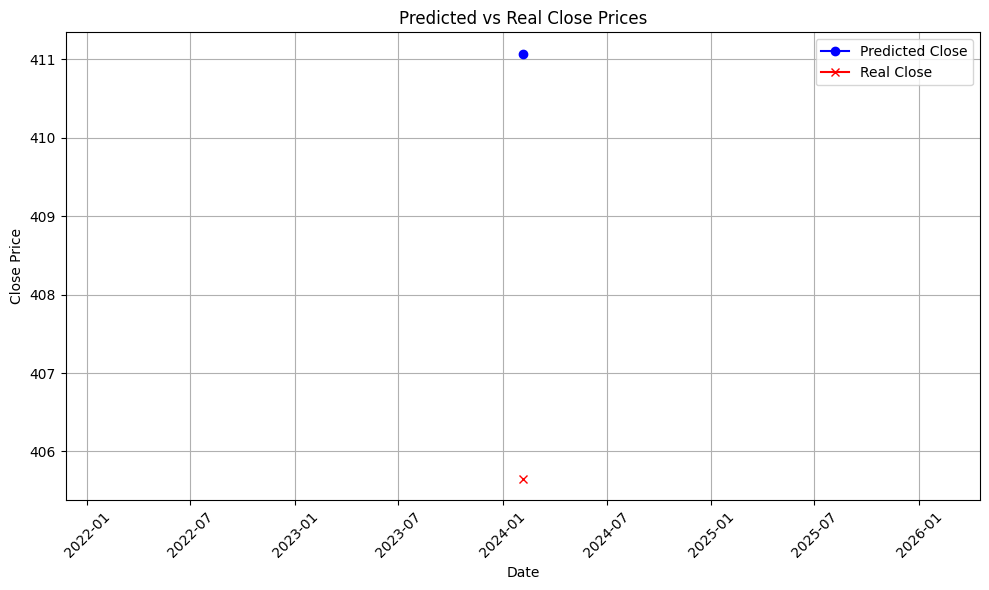

In [36]:
predictions_df = pd.merge(prediction_df, real_data, on='Date')

plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Close'], marker='o', linestyle='-', color='b', label='Predicted Close')
plt.plot(predictions_df['Date'], predictions_df['Close'], marker='x', linestyle='-', color='r', label='Real Close')
plt.title('Predicted vs Real Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
predictions_df

,Date,Predicted_Close,Close
0,2024-02-05,411.075256,405.65


In [38]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming predictions_df is your DataFrame with 'Predicted_Close' and 'Close' columns

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(predictions_df['Close'], predictions_df['Predicted_Close'])
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(predictions_df['Close'], predictions_df['Predicted_Close'])
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R² Score
r2 = r2_score(predictions_df['Close'], predictions_df['Predicted_Close'])
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 5.425256347656273
Mean Squared Error (MSE): 29.43340643778468
R² Score: nan


/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## SARIMA


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Filter the dataframe for SimFinId = 59265
df_filtered = df[df['SimFinId'] == 59265]

# Ensure the dataframe is sorted by date
df_filtered = df_filtered.sort_values(by='Date')

# Set the date column as the index
df_filtered.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_data = df_filtered[:'2024-01-03']
test_data = df_filtered['2024-01-04':]

# Fit the SARIMA model
sarima_model = SARIMAX(train_data['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Make predictions
predictions = sarima_result.get_forecast(steps=len(test_data))
predicted_mean = predictions.predicted_mean

# Create a dataframe for the predictions
prediction_df_sarima = pd.DataFrame(predicted_mean, columns=['predicted_value'])

# Display the predictions
prediction_df_sarima


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03657D+00    |proj g|=  6.30710D-02


/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.92085D+00    |proj g|=  1.23072D-02

At iterate   10    f=  2.91097D+00    |proj g|=  1.51870D-03

At iterate   15    f=  2.91023D+00    |proj g|=  1.84022D-03

At iterate   20    f=  2.91015D+00    |proj g|=  4.93209D-04

At iterate   25    f=  2.91013D+00    |proj g|=  1.58360D-04

At iterate   30    f=  2.91013D+00    |proj g|=  6.93874D-05

At iterate   35    f=  2.91012D+00    |proj g|=  3.21584D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     43      1     0     0   1.932D-05   2.910D+00
  F =   2.9101247857924286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_value


In [ ]:
#help

## ARIMA

In [ ]:
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(p) models for p = 1 to 10 and store BIC values and fitted results
bic_values = {}
models = {}
for p in range(1, 11):
    model = ARIMA(df['log_return'], order=(p, 0, 0))
    results = model.fit()
    bic_values[p] = results.bic
    models[p] = results

# Select the model with the minimum BIC
best_p = min(bic_values, key=bic_values.get)
best_model = models[best_p]

print(f"Best AR model order: AR({best_p}) with BIC: {bic_values[best_p]:.2f}\n")
print(best_model.summary())


/Users/pablocamacho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
